# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

/home/vlad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter
from skimage.transform import rotate, resize
from sklearn.preprocessing import LabelBinarizer
from imgaug import augmenters as iaa
from keras.callbacks import ModelCheckpoint
import pickle

Populating the interactive namespace from numpy and matplotlib


First of all, you have you have to read the data. Run the cell below to unpack data.

In [3]:
from get_data import unpack
unpack('Face_Recognition_data.zip')

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [4]:
RESIZED_SHAPE = (100,100,3)

In [5]:
from pandas import read_csv
from os.path import join
from skimage import transform

def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    
    #load train data
    train_name_list = read_csv('/home/vlad/Documents/face-recognition-task/Face_Recognition_data/image_classification/train/y_train.csv')
    train_name_list = train_name_list.values
    train_files = train_name_list[:,0]
    train_tags = train_name_list[:,1]

    target_h, target_w, target_c = RESIZED_SHAPE
    
    train_shapes = []
    train_imgs = np.zeros((len(train_files),target_h, target_w, target_c))
    i = 0
    for filename in train_files:
        img = imread(join('/home/vlad/Documents/face-recognition-task/Face_Recognition_data/image_classification/train/images/', filename))
        img = img / 255.
        h,w,_ = img.shape
        #print(h/w)
        train_shapes.append((h,w))
        train_imgs[i,:h,:w,:] = np.array(transform.resize(img, RESIZED_SHAPE, mode="reflect"))
        i += 1
         
    #load test data
    test_name_list = read_csv('/home/vlad/Documents/face-recognition-task/Face_Recognition_data/image_classification/test/y_test.csv')
    test_name_list = test_name_list.values
    test_files = test_name_list[:,0]
    test_tags = test_name_list[:,1]

    test_shapes = []
    test_imgs = np.zeros((len(test_files),target_h, target_w, target_c))
    i = 0
    for filename in test_files:
        img = imread(join('/home/vlad/Documents/face-recognition-task/Face_Recognition_data/image_classification/test/images/', filename))
        img = img / 255.
        h,w,_ = img.shape
        test_shapes.append((h,w))
        test_imgs[i,:h,:w,:] = np.array(transform.resize(img, RESIZED_SHAPE, mode="reflect"))
        i += 1
        
    train_labels = dict(zip(train_files, train_tags))
    train_images = dict(zip(train_files, train_imgs))
    test_labels = dict(zip(test_files, test_tags))
    test_images = dict(zip(test_files, test_imgs))
    
    return train_images, train_labels, test_images, test_labels, train_shapes, test_shapes


In [6]:
x_train, y_train, x_test, y_test, train_shapes, test_shapes = load_image_data()
print('%d'%len(x_train), '\ttraining images')
print('%d'%len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [7]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

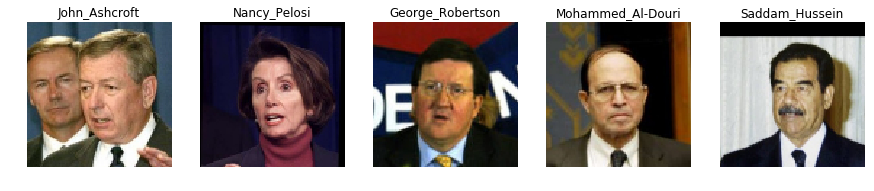

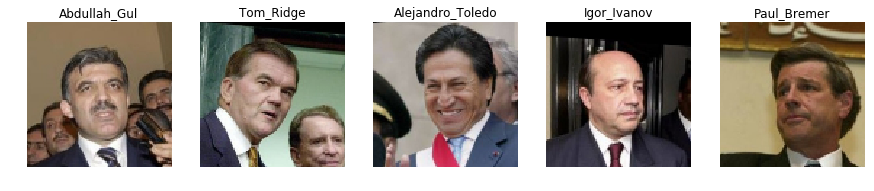

In [9]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [115]:
from pandas import read_csv
from os.path import join
from skimage import transform

def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    
    #load train data
    train_name_list = read_csv('/home/vlad/Documents/face-recognition-task/Face_Recognition_data/video_classification/train/y_train.csv')
    train_name_list = train_name_list.values
    train_files = train_name_list[:,0]
    train_tags = train_name_list[:,1]
    
    target_h, target_w, target_c = RESIZED_SHAPE
    
    train_shapes = []
    train_imgs = np.zeros((len(train_files),target_h, target_w, target_c))
    i = 0
    images = []
    for filename in train_files:
        img = imread(join('/home/vlad/Documents/face-recognition-task/Face_Recognition_data/video_classification/train/images/', filename))
        img = img / 255.
        h,w,_ = img.shape
        train_shapes.append((h,w))
        train_imgs[i,:h,:w,:] = np.array(transform.resize(img, RESIZED_SHAPE, mode="reflect"))
        i += 1
        
   
    #load test data
    test_name_list = read_csv('/home/vlad/Documents/face-recognition-task/Face_Recognition_data/video_classification/test/y_test.csv')
    test_name_list = test_name_list.values
    test_dirs = test_name_list[:,0]
    test_tags = test_name_list[:,1]
    
    test_image_lists = []
    for i, folder in enumerate(test_dirs):
        filenames = os.listdir(join('/home/vlad/Documents/face-recognition-task/Face_Recognition_data/video_classification/test/videos/', str(folder)))
        test_imgs = np.zeros((len(filenames), 360, 360, target_c))
        j = 0
        for filename in filenames:
            img = imread(join('/home/vlad/Documents/face-recognition-task/Face_Recognition_data/video_classification/test/videos/', str(folder), filename))
            img = img / 255.
            h,w,_ = img.shape
            if h > 320:
                resize_ratio = h / 320
                img = transform.resize(img, (int(h/resize_ratio), int(w/resize_ratio), 3))
            #update shape after transformation
            h,w,_ = img.shape    
            img = transform.resize(img, (int(h/2), int(w/2), 3))
            h,w,_ = img.shape
            test_imgs[j,:h,:w,:] = img
            j += 1
        test_image_lists.append(test_imgs)
        
    train_labels = dict(zip(train_files, train_tags))
    train_images = dict(zip(train_files, train_imgs))
    test_labels = dict(zip(test_dirs, test_tags))
    test_images = dict(zip(test_dirs, test_image_lists))
    
    return train_images, train_labels, test_images, test_labels


In [121]:
video_train, v_train_labels, video_test, v_test_labels = load_video_data()
print('%d'%len(video_train), '\ttraining images')
print('%d'%len(video_test), '\ttesting videos')

661 	training images
70 	testing videos


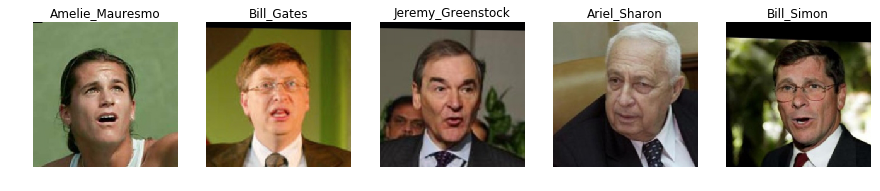

In [175]:
visualize(video_train, train_labels)

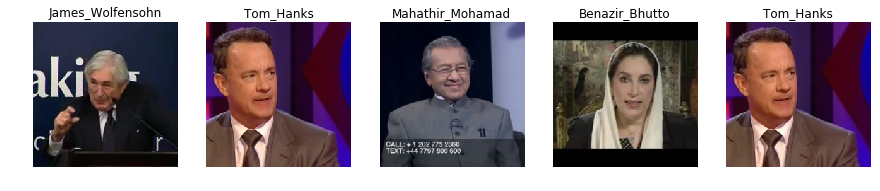

In [176]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).


For face detection and facial keypoint regression you can use your models from the previous tasks.

In [10]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation, Input, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import load_model

In [11]:
IMAGE_SHAPE = (100, 100, 3)

In [12]:
#face detection model - it's a fully convolutional sliding window model; it will take the weights from an analogous fully 
# connected model generating binary prediction of face presence for a 32x32 image
def generate_fcnn_model(image_shape):
    """After model compilation input size cannot be changed.
    
    So, we need create a function to have ability to change size later.
    """
    # Write code here
    # ...
    X_input = Input(shape=image_shape)

    X = Conv2D(64, (3, 3), strides = (1, 1), activation = 'relu', padding='same')(X_input)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(256, (3, 3), strides = (1, 1), activation = 'relu', padding='same')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(512, (3, 3), strides = (1, 1), activation = 'relu', padding='same')(X)
    
    #Dense replacement
    X = Conv2D(512, (8, 8), strides = (1, 1), activation = 'relu', padding='same')(X)

    X = Conv2D(256, (1, 1), strides = (1, 1), activation = 'relu', padding='same')(X)
    #X = Dropout(0.3)(X)
    X = Conv2D(128, (1, 1), strides = (1, 1), activation = 'relu', padding='same')(X)
      
    # This creates a model
    predictions = Conv2D(2, (1, 1), activation='sigmoid')(X)
    return Model(inputs=X_input, outputs=predictions)


In [13]:
fcnn_model = generate_fcnn_model(RESIZED_SHAPE)

fcnn_model.compile(optimizer=Adam(), # You can use another optimizer
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


In [14]:
def generate_model():
    # Classification model
    # You can start from LeNet architecture
    X_input = Input(shape=(32, 32, 3))
    
    # Write code here
    # ...
    X = Conv2D(64, (3, 3), strides = (1, 1), activation='relu', padding='same')(X_input)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(256, (3, 3), strides = (1, 1), activation='relu', padding='same')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(512, (3, 3), strides = (1, 1), activation='relu', padding='same')(X)
    X = Flatten()(X)
    
    X = Dense(512, activation='relu')(X)
    
    X = Dense(256, activation='relu')(X)
    
    X = Dense(128, activation='relu')(X)
    # This creates a model
    predictions = Dense(2, activation='sigmoid')(X)
    
    return Model(inputs=X_input, outputs=predictions)

model = generate_model()

def get_checkpoint():
    return "/home/vlad/Documents/face-detection/data/checkpoints/vk_model-42-0.02.hdf5"

model.load_weights(get_checkpoint())


In [15]:
def copy_weights(base_model, fcnn_model):
    """Set FCNN weights from base model.
    """
    
    new_fcnn_weights = []
    prev_fcnn_weights = fcnn_model.get_weights()
    prev_base_weights = base_model.get_weights()
    
    
    # Write code here
    #first conv layers copies as is, no reshape
    for i in range(0,6):
        new_fcnn_weights.append(prev_base_weights[i])
    
    item = 6
    base_vec = prev_base_weights[item]
    fcnn_vec = prev_fcnn_weights[item]
    new_vec = np.empty(fcnn_vec.shape)
    new_vec = base_vec.reshape(fcnn_vec.shape)
    new_fcnn_weights.append(new_vec)
    
    item = 7  
    new_fcnn_weights.append(prev_base_weights[item])
    
    item = 8
    base_vec = prev_base_weights[item]
    fcnn_vec = prev_fcnn_weights[item]
    new_vec = np.empty(fcnn_vec.shape)
    new_vec[0,0,:,:] = base_vec
    new_fcnn_weights.append(new_vec)
    
    item = 9
    new_fcnn_weights.append(prev_base_weights[item])
    
    item = 10
    base_vec = prev_base_weights[item]
    fcnn_vec = prev_fcnn_weights[item]
    new_vec = np.empty(fcnn_vec.shape)
    new_vec[0,0,:,:] = base_vec    
    new_fcnn_weights.append(new_vec)
    
    item = 11
    new_fcnn_weights.append(prev_base_weights[item])
    
    item = 12
    base_vec = prev_base_weights[item]
    fcnn_vec = prev_fcnn_weights[item]
    new_vec = np.empty(fcnn_vec.shape)
    new_vec[0,0,:,:] = base_vec    
    new_fcnn_weights.append(new_vec)
    
    item = 13
    new_fcnn_weights.append(prev_base_weights[item])

    fcnn_model.set_weights(new_fcnn_weights)



In [16]:
copy_weights(base_model=model, fcnn_model=fcnn_model)


In [18]:
def input_resize_reshape(images):
    images = list(images.values())
    #result_imgs = np.array([transform.resize(image, IMAGE_SHAPE, mode="reflect") for image in images])
    #result_imgs = result_imgs - 0.5
    result_imgs = np.array(images) - 0.5
    return result_imgs



In [19]:
def visualize_heatmap(images, heatmap, n_cols=5, n_rows=1):
    """Visualize heatmap"""
    plt.figure(figsize=(3 * n_cols, 2 * 3 * n_rows))
    for n,i in enumerate(np.arange(n_cols * n_rows)):
        plt.subplot(2 * n_rows, n_cols, n + 1)
        plt.axis('off')
        plt.imshow(images[i])
        
        plt.subplot(2 * n_rows, n_cols, n + 1 + n_cols)
        plt.axis('off')
        plt.imshow(heatmap[i])
    plt.show()

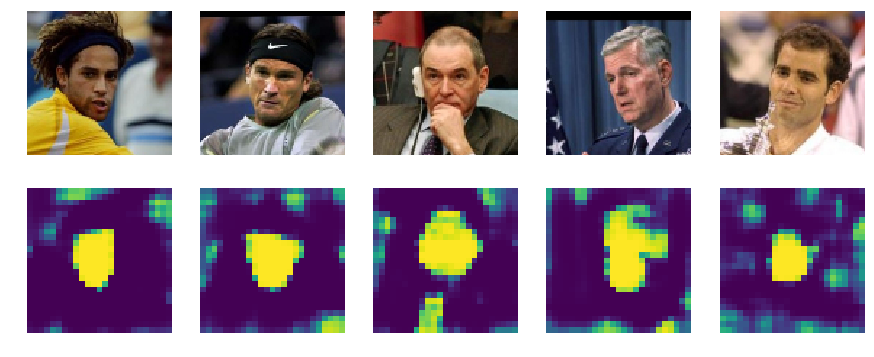

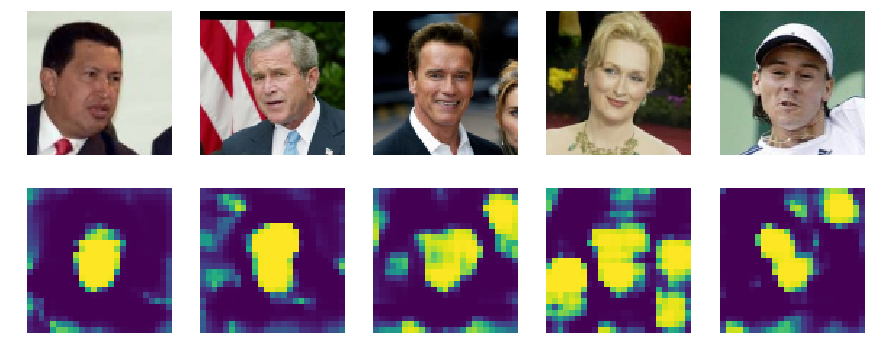

In [20]:
#predictions = fcnn_model.predict(np.array(list(x_train.values())))

predictions = fcnn_model.predict(input_resize_reshape(x_train))
visualize_heatmap(list(x_train.values()), predictions[:, :, :, 1])

# the second row represents some examples which caused me issues that
# had to be addressed at preprocessing: eg see arnold and meryl streep heatmaps
min_ = 14
max_ = min_ + 5
search_keys = range(min_,max_)

sample = {k:x_train[str(k)+'.jpg'] for k in search_keys if str(k)+'.jpg' in x_train}

visualize_heatmap(list(sample.values()), predictions[min_:max_, :, :, 1])


In [21]:
BOX_SIDE = 8


In [22]:
def find_best_box(pred):
    '''
    takes one prediction
    returns the upper left coordinates for the best box
    '''
    
    h,w = pred.shape
    border = 5
    max_sample = 0
    max_h = 0
    max_w = 0

    for i in range(h-border*2-BOX_SIDE):
        for j in range(w-border*2-BOX_SIDE):
            sample_sum = sum(pred[i+border:i+border+BOX_SIDE,j+border:j+border+BOX_SIDE])
            if sample_sum > max_sample:
                max_sample = sample_sum
                max_h = i+border
                max_w = j+border
                
    return max_sample, max_h, max_w


In [36]:
def find_face_box_(prediction):
    '''
    take predictions and images as dictionary
    return dictionary of tuple of h&w coordinates scaled up to resized shape 
    '''

    prediction = prediction[:,:,1]
    
    #multiplier
    m = int(round(IMAGE_SHAPE[0] / prediction.shape[0]))
    
    #this is an empirical adjustment for quality and size of box
    increment = 3
    
    _, start_h, start_w = find_best_box(prediction)
        
    start_h = (start_h) * m
    start_w = (start_w) * m
    end_h = start_h + (BOX_SIDE + increment) * m
    end_w = start_w + (BOX_SIDE + increment) * m
        
    result = [start_h, start_w, end_h, end_w]
        
    return result

In [37]:
def get_framed_face_(image, box):
    '''
    cut face images from the pictures
    return dictionary
    '''
    
    img = image[box[0]:box[2],box[1]:box[3],:]
    img = transform.resize(img, KEYPOINTS_SHAPE, mode="reflect")
        
    return img

In [38]:
def prepare_keypoint_inputs(framed_face):
    '''
    prepare inputs for keypoints extraction
    '''
    h,w,_ = framed_face.shape
    
    framed_faces = np.empty((len(framed_faces_dict), h, w, 3))
    for i, item in enumerate(pred_bboxes):
        img_key = str(i) + '.jpg'
        framed_faces[i,:,:,:] = framed_faces_dict[img_key]
    
    return framed_faces


In [39]:
def extract_eye_coords_(predict_pts):
    '''
    get eye coordinates after running the image through the keypoints detection model
    '''
    eye_coords = [(int((predict_pts[10]+0.5)*100), int((predict_pts[11]+0.5)*100)), 
                     (int((predict_pts[16]+0.5)*100), int((predict_pts[17]+0.5)*100))]
        
    return eye_coords


In [40]:
def find_angle_(eyes):
    '''
    calculate rotation angle based on the eye coordinates
    '''
    w = (eyes[1][0] - eyes[0][0]) * 1.0
    h = (eyes[1][1] - eyes[0][1]) * 1.0
        
    angle = math.degrees(math.tan(h/w))
     
    return angle



In [41]:
def rotate_image_(image, best_box, angle):
    '''
    rotate the image by the degree calculated based on eye coordinates
    '''
    #image frame adjustment: expansion over the initial box cut for coordinate mapping
    s = 15
       
    img = rotate(image, angle)
    img = img[best_box[0]-s:best_box[2]+s,best_box[1]-s:best_box[3]+s,:]
        
    return img


In [42]:
KEYPOINTS_SHAPE = (100, 100, 3)

#fully convolutional fcnn model finds the face on the picture
fcnn_model = generate_fcnn_model(RESIZED_SHAPE)
    
fcnn_model.compile(optimizer=Adam(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
model = generate_model()

#this is an equivalent model with fully connected upper layer
#determining whether a 32x32 input is a face
model.load_weights(get_checkpoint())
    
#copy and reshape weights from fully connected to fully convolutional model
copy_weights(base_model=model, fcnn_model=fcnn_model)

#this model I trained previously finds facial keypoints
keypoints_model = load_model('/home/vlad/Documents/facial-keypoints/keypoints_model.h5')


In [43]:
def preprocess_imgs(img):
    '''
    arguments: image
    return: locate face, map features, rotate image, crop and return image
    '''
    prediction = fcnn_model.predict(np.array(img)-0.5)
    prediction = np.squeeze(prediction)
    best_box = find_face_box_(prediction = prediction)
    framed_face = get_framed_face_(image=img[0], box=best_box)
    predict_pts = keypoints_model.predict(np.expand_dims(framed_face, axis = 0))
    predict_pts = np.squeeze(predict_pts)
    eyes = extract_eye_coords_(predict_pts)
    rotation_angle = find_angle_(eyes=eyes)
    rotated_image = rotate_image_(image=img[0], best_box=best_box, angle=rotation_angle)
    
    return rotated_image
    

In [54]:
def preprocess_data(images):
    '''
    preprocess all images and return as array for classification model input
    '''
    result = []
    for i, item in enumerate(images):
        #print(images[item].shape)
        img = preprocess_imgs([images[item]])
        img = transform.resize(img, (224,224,3))
        result.append(img)
    
    result = np.array(result)
        
    return result

temp = preprocess_data(x_train)
temp.shape

/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(661, 224, 224, 3)

In [46]:
#the first row shows data after preprocessing; the second row (small) shows original data
def visualize_(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    function_default = lambda x:x[0]
    n_ = []
    i_ = []
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        #plt.imshow(function_default([data[i]]))
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
        n_.append(n)
        i_.append(i)
    plt.show()
    for j in range(len(i_)):
        plt.subplot(n_rows,n_cols,j+1)
        plt.axis('off')
        plt.imshow(function_default([data[i_[j]]]))
        #plt.imshow(function([data[i_[j]]]))
        plt.title(labels[i_[j]])
        

#### Visualization of preprocessing

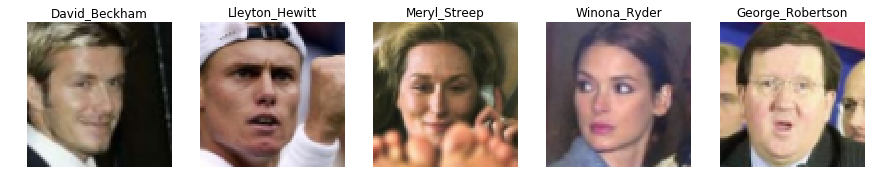

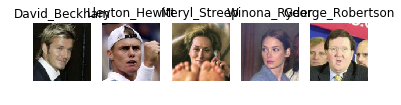

In [58]:
#visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])
visualize_(x_train, y_train, function = lambda x:preprocess_imgs(x))

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [49]:
import h5py
from keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [50]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [51]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [52]:
#from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
import cv2
from os.path import join
class Classifier():
    def __init__(self, nn_model):
        """Your implementation"""
        
        self.nn_model = nn_model
        

    def generator(self, features, labels, batch_size=32):

        #define methods for gentle image augmentation
        seq = iaa.Sequential([
            iaa.Affine(scale=(0.9, 1.1)), #iaa.Crop(px=(0, 10)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.Multiply((0.95, 1.1), per_channel=True),
            #iaa.Add((-5, 5)),
            iaa.Fliplr(0.5), # horizontally flip 50% of the images
            iaa.GaussianBlur(sigma=(0, 1)) # blur images with a sigma of 0 to 1
        ])

        #create empty array
        batch_features = np.zeros((batch_size, 500))
        batch_labels = np.zeros((batch_size,107))

        while True:
            for i in range(batch_size):
                # choose random index in features
                index = random.choice(len(features),1)
                preprocessed_features = seq.augment_images(features[index])

                batch_features[i] = model.predict(x=preprocessed_features)
                batch_labels[i] = labels[index]

            yield batch_features, batch_labels

    
    def fit(self, train_imgs, train_labels,test_imgs, test_labels, num_epochs = 50):
        """Your implementation"""
        
        #preprocess data inputs
        X_train_preprocessed = preprocess_data(train_imgs)
        X_test_preprocessed = preprocess_data(test_imgs)
        
        #create one-hot encoded model label inputs
        self.lb = LabelBinarizer()
        self.lb.fit(list(y_train.values()))
        
        labels_train =  self.lb.transform(list(train_labels.values()))
        labels_test =  self.lb.transform(list(y_test.values()))
        
        self.nn_model.compile(optimizer=Adam(), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

        #extract features from pre-trained model
        features_train = self.nn_model.predict(x=X_train_preprocessed)
        features_test = self.nn_model.predict(x=X_test_preprocessed)
        
        #add model that will train classifier based on extracted features
        self.classify_model = Sequential()
        self.classify_model.add(Dense(500, activation='relu', input_shape=(500,)))
        self.classify_model.add(Dropout(0.7))
        self.classify_model.add(Dense(107, activation='softmax'))

        self.classify_model.compile(optimizer=Adam(), 
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        
        gen = self.generator(features=X_train_preprocessed, labels=labels_train, batch_size=32)
        
        checkpointer = ModelCheckpoint(filepath='/home/vlad/Documents/face-recognition-task/model_data/weights.hdf5',
                                       monitor='val_acc', verbose=0, save_best_only=True)
        self.classify_model.fit_generator(gen, validation_data=(features_test, labels_test), samples_per_epoch=50,
                   epochs=num_epochs, callbacks=[checkpointer])

         
    def get_best_weights(self):
         return '/home/vlad/Documents/face-recognition-task/model_data/weights.hdf5'

        
    
    def classify_images(self, test_imgs, test_labels):
        """Your implementation"""
        
        X_test_preprocessed = preprocess_data(test_imgs)
        features_test = self.nn_model.predict(x=X_test_preprocessed)
        self.classify_model.load_weights(self.get_best_weights())
        y_out = self.classify_model.predict(features_test)
        y_out = list(np.argmax(y_out, axis = 1))
        indexes = list(test_labels.keys())
        y_out = dict(zip(indexes, y_out))
        labels_test =  self.lb.transform(list(test_labels.values()))
        y_test_indexed = dict(zip(indexes, list(np.argmax(labels_test, axis = 1))))
        
        return y_out, y_test_indexed
   
        
    def classify_videos(self, test_video):
        """Your implementation"""
        pass

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [53]:
img_classifier = Classifier(model)
img_classifier.fit(x_train, y_train, x_test, y_test, num_epochs = 100)


/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/vlad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=(array([[0..., epochs=100, callbacks=[<keras.ca..., steps_per_epoch=50)`


Epoch 1/100
50/50 [==============================] - 17s 346ms/step - loss: 4.6531 - acc: 0.0425 - val_loss: 4.6379 - val_acc: 0.1064
Epoch 2/100
50/50 [==============================] - 17s 346ms/step - loss: 4.5879 - acc: 0.0719 - val_loss: 4.5773 - val_acc: 0.0842
Epoch 3/100
50/50 [==============================] - 17s 346ms/step - loss: 4.4867 - acc: 0.1050 - val_loss: 4.5100 - val_acc: 0.0903
Epoch 4/100
50/50 [==============================] - 18s 353ms/step - loss: 4.3930 - acc: 0.1619 - val_loss: 4.4086 - val_acc: 0.1324
Epoch 5/100
50/50 [==============================] - 18s 350ms/step - loss: 4.2274 - acc: 0.3137 - val_loss: 4.2844 - val_acc: 0.2908
Epoch 6/100
50/50 [==============================] - 18s 355ms/step - loss: 4.0394 - acc: 0.3775 - val_loss: 4.1258 - val_acc: 0.3366
Epoch 7/100
50/50 [==============================] - 17s 343ms/step - loss: 3.8464 - acc: 0.4281 - val_loss: 3.9356 - val_acc: 0.4356
Epoch 8/100
50/50 [==============================] - 18s 350ms

Epoch 62/100
50/50 [==============================] - 19s 375ms/step - loss: 0.0962 - acc: 0.9969 - val_loss: 0.3355 - val_acc: 0.9394
Epoch 63/100
50/50 [==============================] - 19s 374ms/step - loss: 0.0950 - acc: 0.9956 - val_loss: 0.3290 - val_acc: 0.9468
Epoch 64/100
50/50 [==============================] - 19s 373ms/step - loss: 0.0907 - acc: 0.9969 - val_loss: 0.3260 - val_acc: 0.9480
Epoch 65/100
50/50 [==============================] - 19s 375ms/step - loss: 0.0861 - acc: 0.9956 - val_loss: 0.3206 - val_acc: 0.9493
Epoch 66/100
50/50 [==============================] - 18s 362ms/step - loss: 0.0779 - acc: 0.9981 - val_loss: 0.3169 - val_acc: 0.9443
Epoch 67/100
50/50 [==============================] - 18s 362ms/step - loss: 0.0790 - acc: 0.9988 - val_loss: 0.3128 - val_acc: 0.9480
Epoch 68/100
50/50 [==============================] - 18s 364ms/step - loss: 0.0818 - acc: 0.9956 - val_loss: 0.3127 - val_acc: 0.9381
Epoch 69/100
50/50 [==============================] - 1

In [55]:

y_out, y_test_indexed = img_classifier.classify_images(x_test, y_test)

/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [56]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [57]:
print(check_test(y_out, y_test_indexed))

Classification accuracy is 0.9530


In [22]:
# I AM FINISHING THE VIDEO CLASSIFICATION PART AND WILL UPLOAD IT SHORTLY. EVERYTHING IS THE SAME EXCEPT THE TEST SET 
# WHICH IS A COLLECTION OF JPG IMAGES REPRESENTING VIDEOS. THE CHALLENGE THAT NEEDS TO BE ADDRESSED HERE IS THE 
# INCONSISTENT SCALE OF IMAGES IE THE FACE FINDER MODEL EXPECTS TO SEE A FACE OF SPECIFIC SIZE, BUT MAY GET CONFUSED BY A 
# TOO LARGE FACE IMAGE. THE SIMPLEST WAY OF SOLVING THIS IN THIS CASE IS TO FIND AN INDIVIDUAL OPTIMAL SCALE TO RESIZE 
# EACH INDIVIDUAL VIDEO SET

### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [ ]:
video_classifier = Classifier(model)
video_classifier.fit(video_train, train_labels)
y_video_out = video_classifier.classify_videos(video_test)

In [ ]:
print check_test(y_video_out, test_labels)